In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib, os, glob
import warnings
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from IPython.display import Image
from ipywidgets import interact, interact_manual
import qgrid
#import statistics as st
#from datetime import datetime as dt
#import datetime as dt2
#import ipywidgets as widgets
#from astropy.time import Time # pip install astropy'

warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = True

### This script can combine multiple standard peak intensity data files for following analysis, which explore the relationships between the peaks at LSB, USB, P0 & P1 and other parameters (LO frequency, Tsys, utdate, etc.).
### prerequisite:  one has extracted the peak intensity data as one or multiple files (stats-max.csv) and one also the sql data files (sql.tsv) 

In [32]:
# 20200818
# 20210901 more general file reading and merging.
# Xuejian Jiang
data_dir = './'        # the path to your data file (can contain subfolders)
data_filename = '.csv' # check your csv file name.
sql_filename  = '.tsv'

csv_filelist = []
sql_filelist = []
for root, dirs, files in os.walk(data_dir):  # find any file that matches your filename
    for file in files:
        if(file.endswith(data_filename)):
            csv_filelist.append(os.path.join(root,file))
        if(file.endswith(sql_filename)):
            sql_filelist.append(os.path.join(root,file))

datalist = []
sqllist  = []

for csv in csv_filelist:
    df = pd.read_csv(csv, index_col=None, header=0)
    datalist.append(df)
data = pd.concat(datalist, axis=0, ignore_index=True)

for sql in sql_filelist:
    df = pd.read_csv(sql, index_col=None, header=0,  sep='\t')
    sqllist.append(df)
sql_data = pd.concat(sqllist, axis=0, ignore_index=True)

# get range of utdate
date_range = [str(data.iloc[0,1]), str(data.iloc[-1,1])]
print(date_range)

['20200620', '20200825']


In [33]:
data

,pol,utdate,obsnum,subsysnr,object,molecule,transition,obs_sb,peak,tsys,bwmode
0,p0,20200620,23,1,IRC+10216,CS,5-4,LSB,10.64950,286.1874,250MHzx8192
1,p0,20200624,17,1,IRC+10216,CS,5-4,LSB,11.03010,142.8066,250MHzx8192
2,p0,20200627,17,1,IRC+10216,CS,5-4,LSB,10.45690,162.8927,250MHzx8192
3,p1,20200620,23,1,IRC+10216,CS,5-4,LSB,11.01270,271.2127,250MHzx8192
4,p1,20200624,17,1,IRC+10216,CS,5-4,LSB,11.65560,133.8225,250MHzx8192
...,...,...,...,...,...,...,...,...,...,...,...
1651,both,20200825,17,2,NGC6334I,H-13-CN,3-2,USB,4.34514,163.2386,1000MHzx2048
1652,both,20200825,20,2,CRL2688,NoLine,NoLine,LSB,2.33113,149.2447,1000MHzx2048
1653,both,20200825,21,2,CRL2688,H-13-CN,3-2,USB,2.77794,152.9197,1000MHzx2048
1654,both,20200825,22,2,W75N,NoLine,NoLine,LSB,2.28000,141.1868,1000MHzx2048


In [34]:
# add a column "ratio_to_p0"

p0data   = data[data['pol']== 'p0']
p1data   = data[data['pol']== 'p1']
bothdata = data[data['pol']== 'both']
index = pd.Index(range(0,len(p1data)))
p0data.index   = index
p1data.index   = index
bothdata.index = index

p0data['ratio_to_p0']   = p0data['peak']  /p0data['peak']
p1data['ratio_to_p0']   = p1data['peak']  /p0data['peak']
bothdata['ratio_to_p0'] = bothdata['peak']/p0data['peak']

p0lsbdata = p0data[p0data['obs_sb']== 'LSB']

data = p0data.append(p1data).append(bothdata)


In [35]:
# get lofreq from SQL results

sql_data.rename(columns={'transiti':'transition', 'subbands':'bwmode'},inplace=True)
sql_data.loc[sql_data.msbtitle.str.contains('H13CN'), 'molecule'] = 'H-13-CN'
data = pd.merge(data, sql_data, on=['utdate','obsnum','obs_sb','bwmode','object','subsysnr'],how='left')
data.rename(columns={'obs_sb':'sideband', 'molecule_y':'molecule'},inplace=True)

data['Date'] = pd.to_datetime(data['utdate'], format='%Y%m%d')
# There are a few data with odd tsys data record, and I exclude them from the table.
data = data[data['tsys']!='*']
data['tsys'] = np.float64(data['tsys'])
data = data[data['project'].str.contains('M20AEC36|M20BEC36|JCMTCAL') | pd.isna(data['project'])]
#data = data[data['msbtitle'].str.contains('redshift|radio|opt') == False ]



In [36]:
# run his cell if one wants to explore and check the table.
datau = data[(data.molecule=='CO') & (data.utdate>20200721) & (data.pol == 'both') & (data.bwmode == '250MHzx8192') & 
            (data.sideband == 'USB')]
datal = data[(data.molecule=='CO') & (data.utdate>20200721) & (data.pol == 'both') & (data.bwmode == '250MHzx8192') &
            (data.sideband == 'LSB')]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(datau)
len(datau)

,pol,utdate,obsnum,subsysnr,object,molecule_x,transition_x,sideband,peak,tsys,bwmode,ratio_to_p0,project,obs_type,file_id,msbtitle,lofreqs,restfreq,molecule,transition_y,Date
1370,both,20200722,3,1,EL90,CO,2-1,USB,7.15098,144.3962,250MHzx8192,0.754413,M20AEC36,science,a20200722_00003_01_0001.sdf,Tsys CO(2-1) radio-300,224.538000,230.538,CO,2 - 1,2020-07-22
1371,both,20200722,4,1,EL90,CO,2-1,USB,7.02935,150.9651,250MHzx8192,0.516033,M20AEC36,science,a20200722_00004_01_0001.sdf,Tsys CO(2-1) radio-300,224.538000,230.538,CO,2 - 1,2020-07-22
1372,both,20200722,16,1,16293-2422,CO,2-1,USB,17.74950,175.9819,250MHzx8192,1.003619,JCMTCAL,science,a20200722_00016_01_0001.sdf,16293-2422 CO(2-1) 230.5380,224.525910,230.538,CO,2 - 1,2020-07-22
1375,both,20200722,21,1,EL60,CO,2-1,USB,13.51520,139.6870,250MHzx8192,0.850992,M20AEC36,science,a20200722_00021_01_0001.sdf,Tsys CO(2-1) radio-300,224.538000,230.538,CO,2 - 1,2020-07-22
1376,both,20200722,22,1,EL60,CO,2-1,USB,4.70683,137.0175,250MHzx8192,0.454617,M20AEC36,science,a20200722_00022_01_0001.sdf,Tsys CO(2-1) radio-300,224.538000,230.538,CO,2 - 1,2020-07-22
1392,both,20200729,114,1,test2,CO,2-1,USB,7.55487,122.5836,250MHzx8192,0.810827,M20AEC36,science,a20200729_00114_01_0001.sdf,morning Tsys CO(2-1) radio-300,224.772741,230.538,CO,2 - 1,2020-07-29
1397,both,20200802,10,1,16293-2422,CO,2-1,USB,19.14260,148.2436,250MHzx8192,1.020699,JCMTCAL,science,a20200802_00010_01_0001.sdf,16293-2422 CO(2-1) 230.5380,224.523426,230.538,CO,2 - 1,2020-08-02
1440,both,20200807,76,1,W75N,CO,2-1,USB,28.22500,188.9144,250MHzx8192,1.019693,M20BEC36,science,a20200807_00076_01_0001.sdf,W75N 12CO 13CO 250MHz,224.543981,230.538,CO,2 - 1,2020-08-07
1441,both,20200807,77,1,W75N,CO,2-1,USB,28.32770,187.4888,250MHzx8192,1.015348,M20BEC36,science,a20200807_00077_01_0001.sdf,W75N CO IF 6 USB,224.543977,230.538,CO,2 - 1,2020-08-07
1455,both,20200807,88,1,W3(OH),CO,2-1,USB,22.55240,154.7074,250MHzx8192,1.007663,M20BEC36,science,a20200807_00088_01_0001.sdf,W3(OH) 12CO and 13CO 250MHz,224.591533,230.538,CO,2 - 1,2020-08-07


15

In [37]:
# RxA3 standard values, to use HAPR values one needs to update this list manually
receiver = 'RxA3_1000MHz' # adpot 1000MHz value
#receiver = 'HARP_1000MHz' # adpot 1000MHz value

data[receiver] = 0.
for i in range(0,len(data)):
	if data['molecule'].iloc[i] == 'CO':
		if data['object'].iloc[i] == 'W3(OH)': data[receiver].iloc[i] = 20.4
		if data['object'].iloc[i] == 'IRC+10216': data[receiver].iloc[i] = 20.8
		if data['object'].iloc[i] == '16293-2422': data[receiver].iloc[i] = 16.1
		if data['object'].iloc[i] == 'NGC6334I': data[receiver].iloc[i] = 32.0
		if data['object'].iloc[i] == 'G34.3': data[receiver].iloc[i] = 20.7
		if data['object'].iloc[i] == 'W75N': data[receiver].iloc[i] = 27.5
		if data['object'].iloc[i] == 'CRL2688': data[receiver].iloc[i] = 6.15
		if data['object'].iloc[i] == 'N7538IRS1': data[receiver].iloc[i] = 22.4
	if data['molecule'].iloc[i] == 'CS':
		if data['object'].iloc[i] == 'W3(OH)': data[receiver].iloc[i] = 4.75
		if data['object'].iloc[i] == 'IRC+10216': data[receiver].iloc[i] = 5.85
		if data['object'].iloc[i] == '16293-2422': data[receiver].iloc[i] = 5.0
		if data['object'].iloc[i] == 'NGC6334I': data[receiver].iloc[i] = 10.6
		if data['object'].iloc[i] == 'G34.3': data[receiver].iloc[i] = 9.2
		if data['object'].iloc[i] == 'W75N': data[receiver].iloc[i] = 6.62
		if data['object'].iloc[i] == 'CRL2688': data[receiver].iloc[i] = 0.81
		if data['object'].iloc[i] == 'N7538IRS1': data[receiver].iloc[i] = 6.3
	if data['molecule'].iloc[i] == 'CH3OH':
		if data['object'].iloc[i] == 'W3(OH)': data[receiver].iloc[i] = 2.61
		if data['object'].iloc[i] == 'IRC+10216': data[receiver].iloc[i] = 0
		if data['object'].iloc[i] == '16293-2422': data[receiver].iloc[i] = 0.85
		if data['object'].iloc[i] == 'NGC6334I': data[receiver].iloc[i] = 5.75
		if data['object'].iloc[i] == 'G34.3': data[receiver].iloc[i] = 3.89
		if data['object'].iloc[i] == 'W75N': data[receiver].iloc[i] = 3.09
		if data['object'].iloc[i] == 'CRL2688': data[receiver].iloc[i] = 0.
		if data['object'].iloc[i] == 'N7538IRS1': data[receiver].iloc[i] = 1.41          
data['ratio_to_'+receiver] = data['peak']/data[receiver]


In [38]:
# print the median of different sideband/pol.

print("CO")
print(np.median(data[data['molecule']=='CO'][data['pol']=='p0'][data['sideband']=='LSB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CO'][data['pol']=='p1'][data['sideband']=='LSB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CO'][data['pol']=='both'][data['sideband']=='LSB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CO'][data['pol']=='p0'][data['sideband']=='USB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CO'][data['pol']=='p1'][data['sideband']=='USB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CO'][data['pol']=='both'][data['sideband']=='USB']['ratio_to_'+receiver]))

print("CS")
print(np.median(data[data['molecule']=='CS'][data['pol']=='p0'][data['sideband']=='LSB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CS'][data['pol']=='p1'][data['sideband']=='LSB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CS'][data['pol']=='both'][data['sideband']=='LSB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CS'][data['pol']=='p0'][data['sideband']=='USB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CS'][data['pol']=='p1'][data['sideband']=='USB']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CS'][data['pol']=='both'][data['sideband']=='USB']['ratio_to_'+receiver]))

# print("CH3OH")
# print(np.median(data[data['molecule']=='CH3OH'][data['pol']=='p0'][data['sideband']=='LSB']['ratio_to_'+receiver]))
# print(np.median(data[data['molecule']=='CH3OH'][data['pol']=='p1'][data['sideband']=='LSB']['ratio_to_'+receiver]))
# print(np.median(data[data['molecule']=='CH3OH'][data['pol']=='both'][data['sideband']=='LSB']['ratio_to_'+receiver]))
# print(np.median(data[data['molecule']=='CH3OH'][data['pol']=='p0'][data['sideband']=='USB']['ratio_to_'+receiver]))
# print(np.median(data[data['molecule']=='CH3OH'][data['pol']=='p1'][data['sideband']=='USB']['ratio_to_'+receiver]))
# print(np.median(data[data['molecule']=='CH3OH'][data['pol']=='both'][data['sideband']=='USB']['ratio_to_'+receiver]))
# 
# print("H13CN peak (K)")
# print(np.median(data[data['molecule']=='H-13-CN'][data['pol']=='p0'][data['sideband']=='LSB'][data['subsysnr']==2]['peak']))
# print(np.median(data[data['molecule']=='H-13-CN'][data['pol']=='p1'][data['sideband']=='LSB'][data['subsysnr']==2]['peak']))
# print(np.median(data[data['molecule']=='H-13-CN'][data['pol']=='both'][data['sideband']=='LSB'][data['subsysnr']==2]['peak']))
# print(np.median(data[data['molecule']=='H-13-CN'][data['pol']=='p0'][data['sideband']=='USB'][data['subsysnr']==2]['peak']))
# print(np.median(data[data['molecule']=='H-13-CN'][data['pol']=='p1'][data['sideband']=='USB'][data['subsysnr']==2]['peak']))
# print(np.median(data[data['molecule']=='H-13-CN'][data['pol']=='both'][data['sideband']=='USB'][data['subsysnr']==2]['peak']))


CO
1.0683527272727273
1.1275563636363637
1.0981163636363636
1.1463700504658385
1.1764349767080744
1.1595353260869565
CS
1.655119
1.7119941208459215
1.6805884622356495
1.711442286220938
1.7597583081570998
1.7251274622356494


In [39]:
print(np.median(data[data['molecule']=='CO']['ratio_to_'+receiver]))
print(np.median(data[data['molecule']=='CS']['ratio_to_'+receiver]))

1.1100130081300812
1.7049839577039274


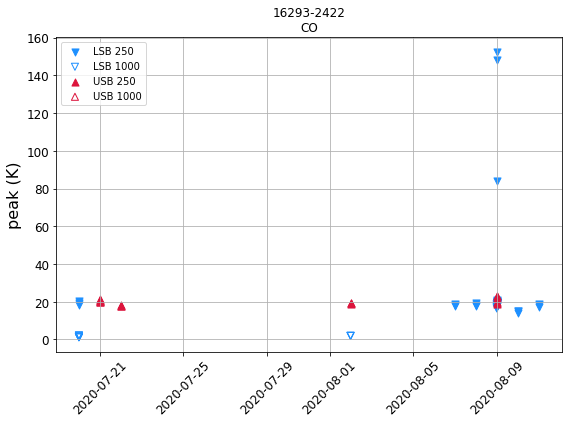

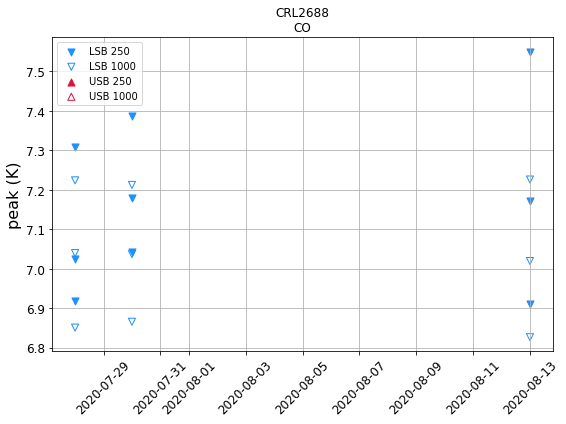

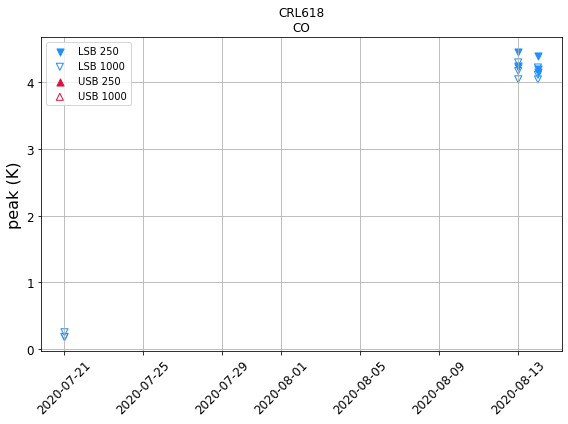

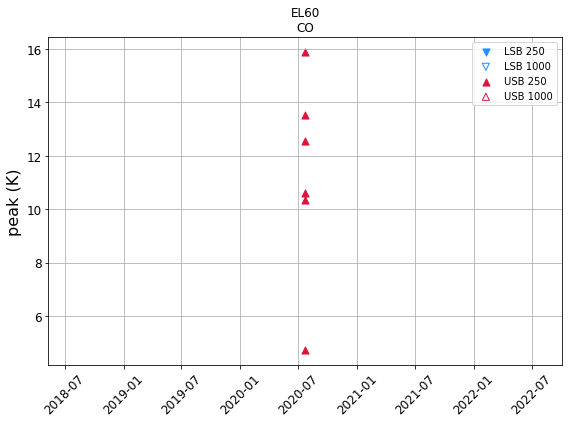

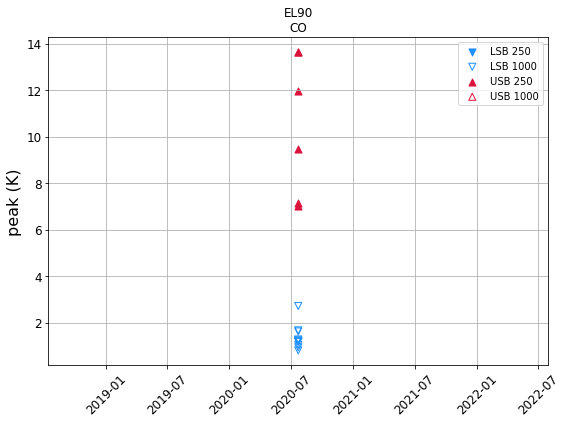

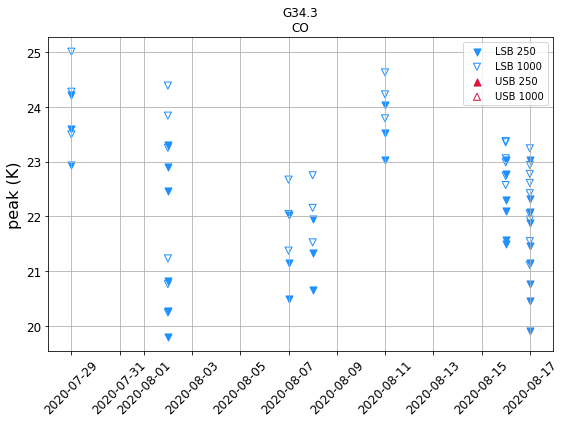

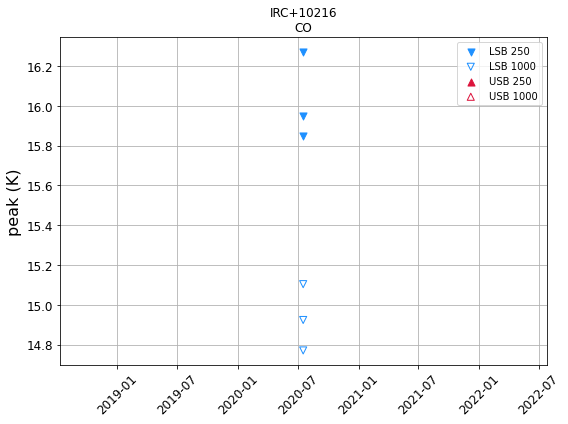

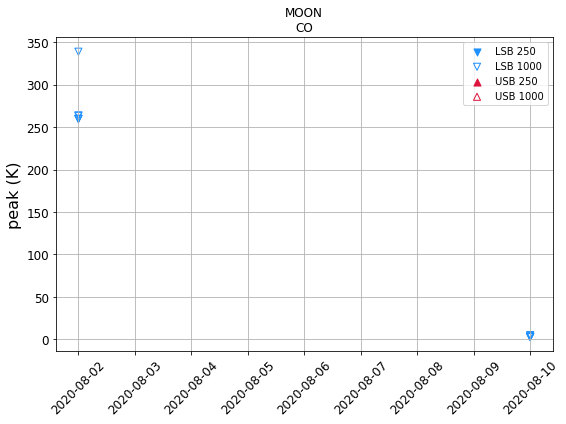

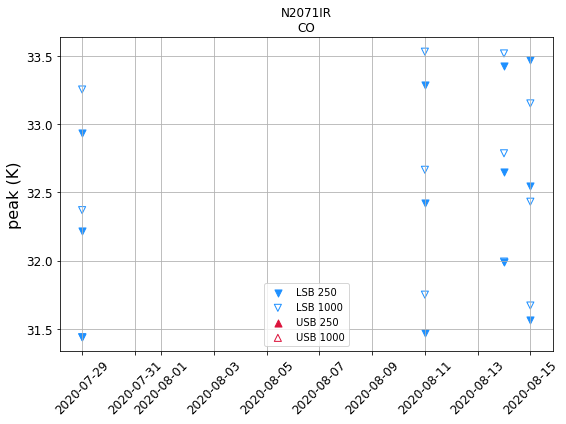

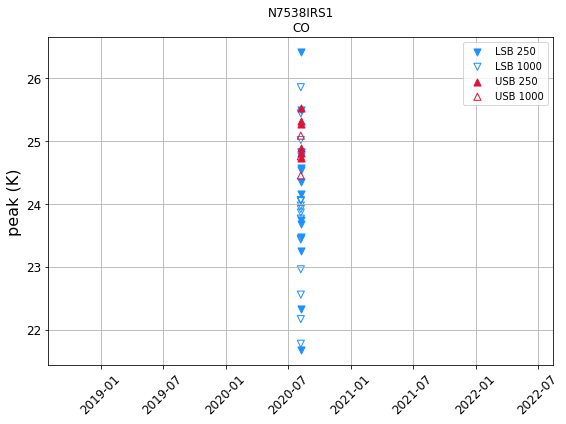

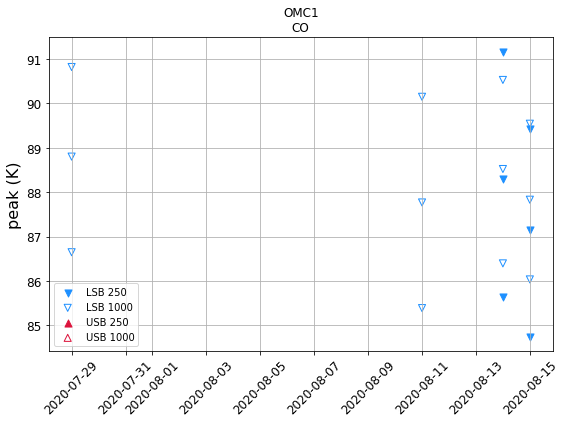

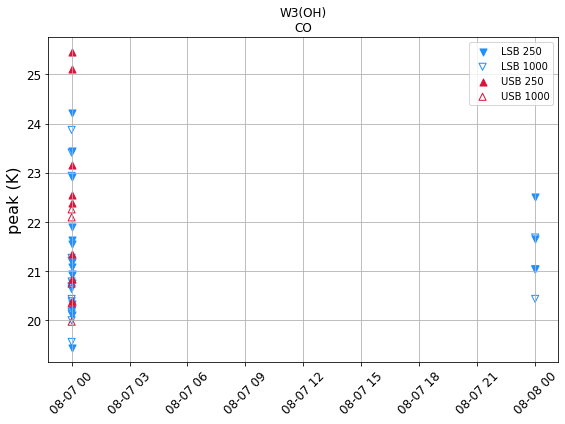

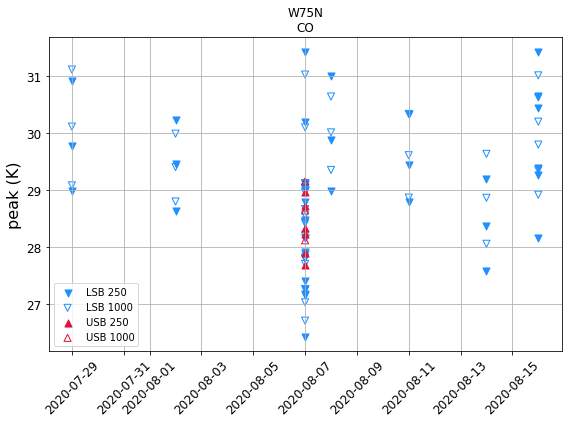

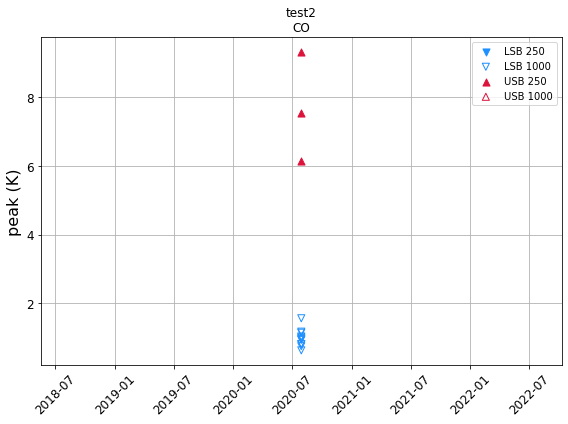

In [40]:
# Sideband vs utdate
if os.path.isdir('figures') == 0:     os.makedirs('figures')

bw_ = ['250MHzx8192', '1000MHzx2048']
sb_ = ['LSB','USB']

molecule = "CO"
for target in np.unique(data['object']):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for sb in sb_:
        color = 'dodgerblue' if sb == 'LSB' else 'crimson'
        for bw in bw_:
            marker = '^' if sb == 'USB' else 'v'
            fc = 'none' if bw == '1000MHzx2048' else color
            d = data[(data['object'] == target) & (data['sideband'] == sb) & 
                     (data['bwmode']== bw) & (data['molecule'] == molecule)]
            x = d['Date'];  y = d['peak']
            ax.scatter(x, y, s=50, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+bw.split()[0][0:-8])
    #ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
    plt.title(target + '\n'+ molecule)
    plt.legend()
    plt.ylabel('peak (K)', fontsize = 16)
    ax.tick_params('x', labelrotation=45, labelsize=12)
    ax.tick_params('y', labelsize=12)
    fig.tight_layout()
    fig.savefig('figures/'+target+'_'+molecule+'_peak.png')

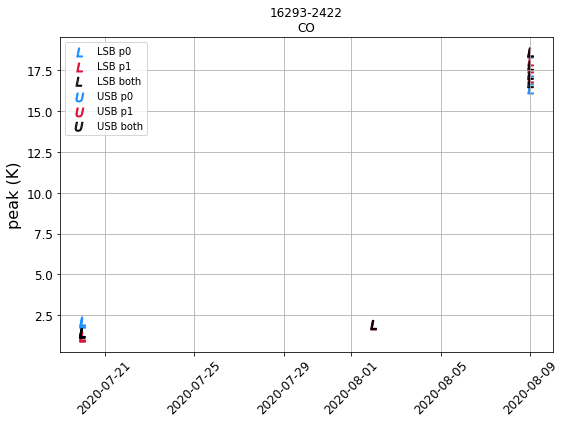

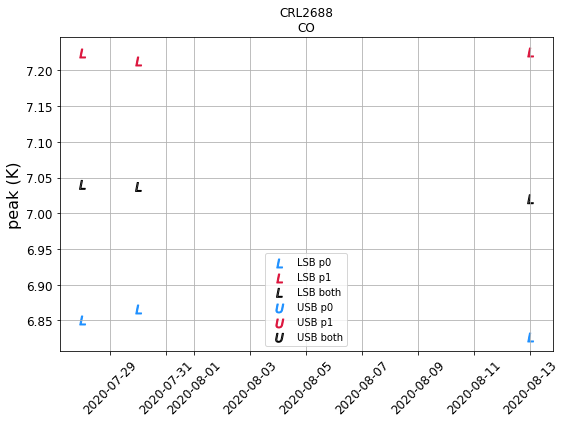

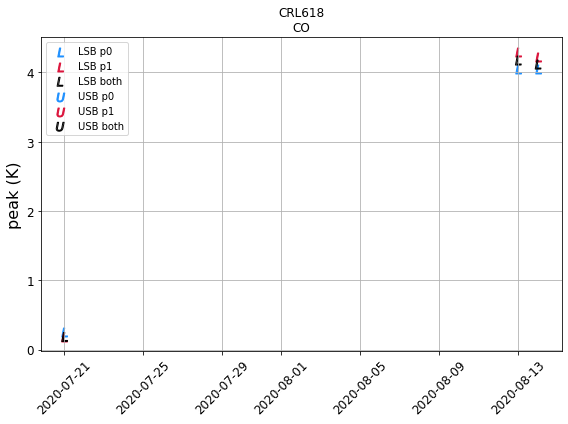

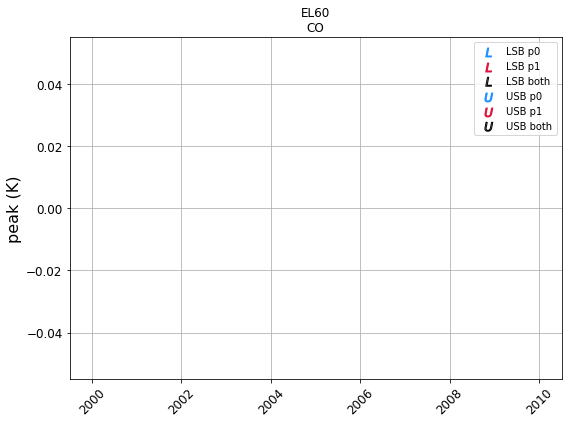

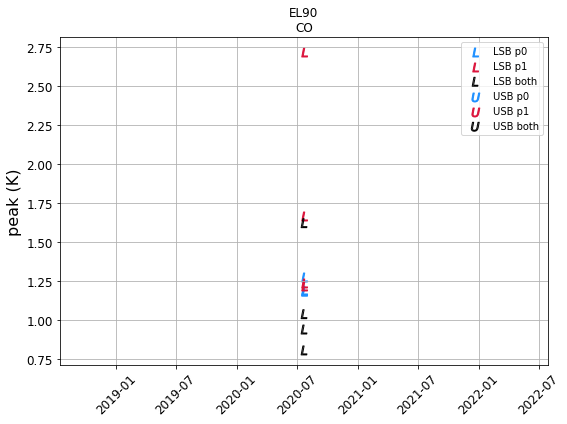

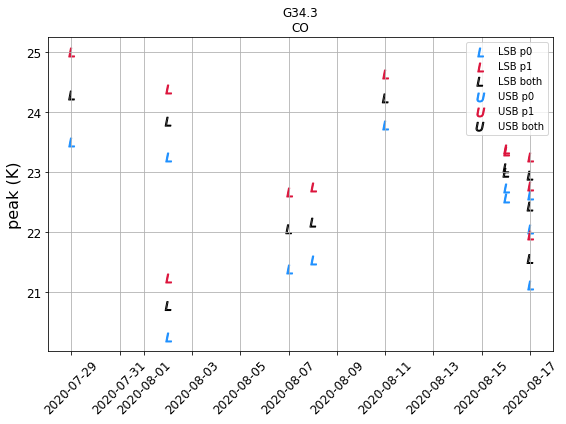

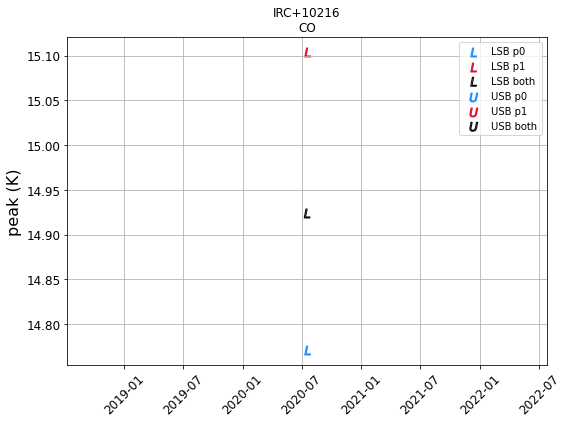

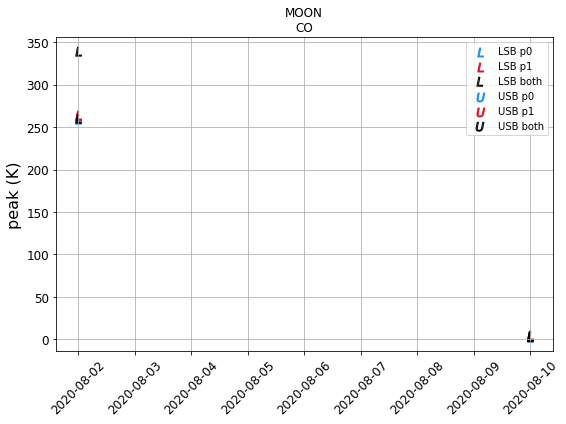

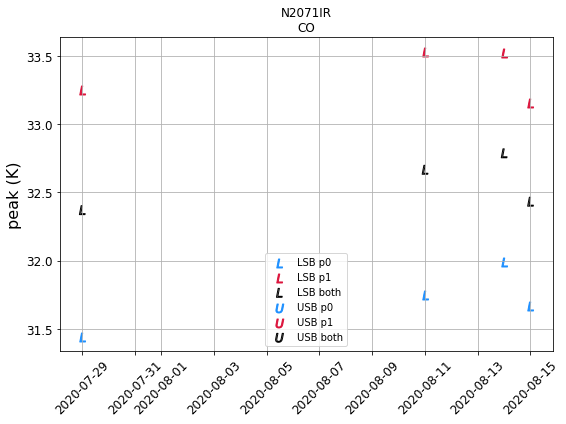

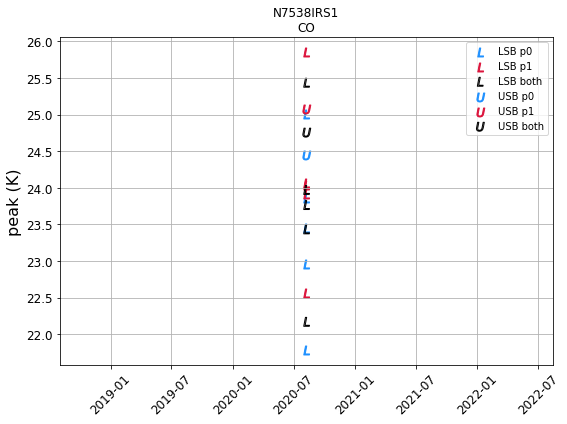

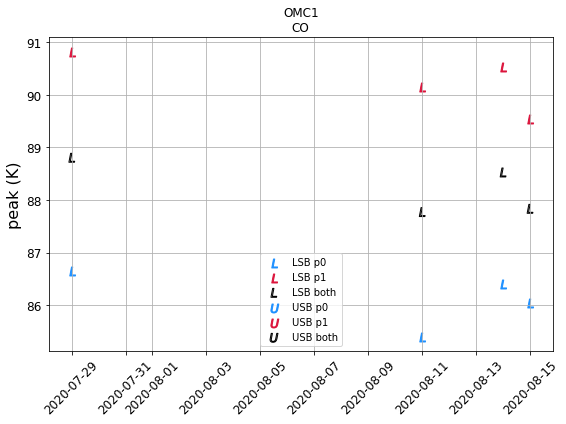

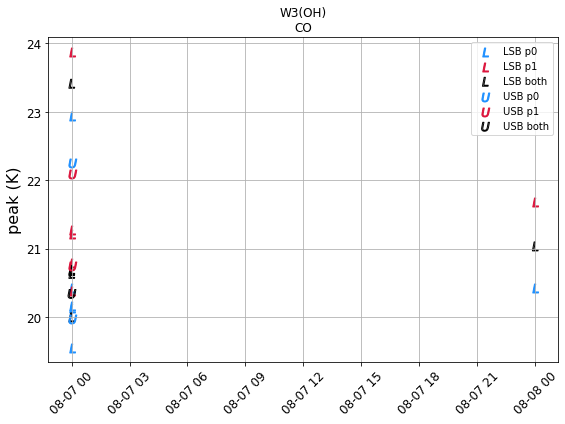

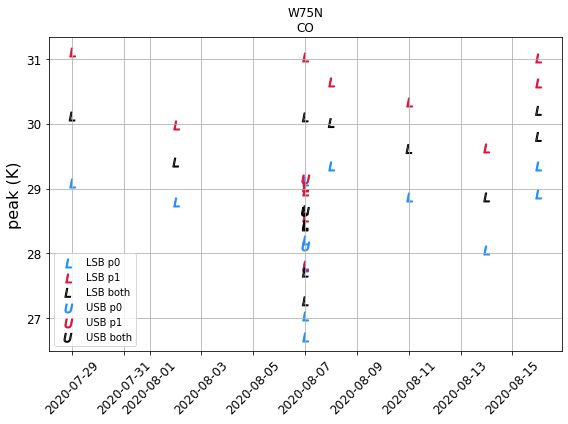

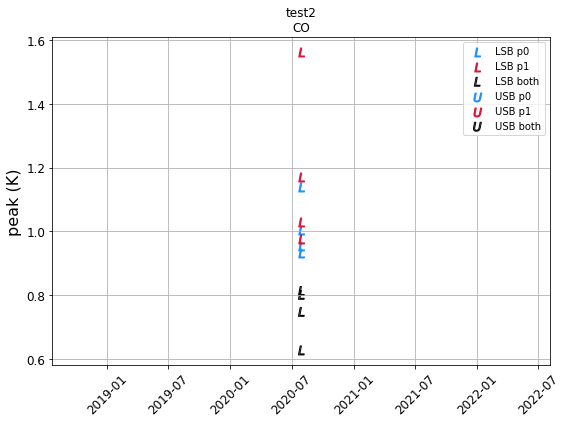

In [41]:
# Sideband and pol vs utdate for CO

bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p0','p1','both']

molecule = "CO"
if(os.path.isdir('figures/'+molecule)==0): os.mkdir('figures/'+molecule)

for target in np.unique(data['object']):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for sb in sb_:
        for pol in pol_:
            if(pol == 'p0'): 
                color = 'dodgerblue'
                fc ='dodgerblue' 
            elif(pol == 'p1'):
                color = 'crimson'
                fc = 'crimson'
            elif(pol=='both'): 
                color ='black'
                fc = 'none'
            #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
            marker = '$U$' if sb == 'USB' else '$L$'
            d = data[(data['object'] == target) & (data['sideband'] == sb) & (data['bwmode']== bw_) &
                     (data['pol'] == pol) & (data['molecule'] == molecule)]
            x = d['Date'];  y = d['peak']
            ax.scatter(x, y, s=80, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+pol)
    #ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
    plt.title(target + '\n'+ molecule)
    plt.legend()
    plt.ylabel('peak (K)', fontsize = 16)
    ax.tick_params('x', labelrotation=45, labelsize=12)
    ax.tick_params('y', labelsize=12)
    fig.tight_layout()
    fig.savefig('figures/'+molecule +"/"+target+'_'+molecule+'_pol_peak.png')

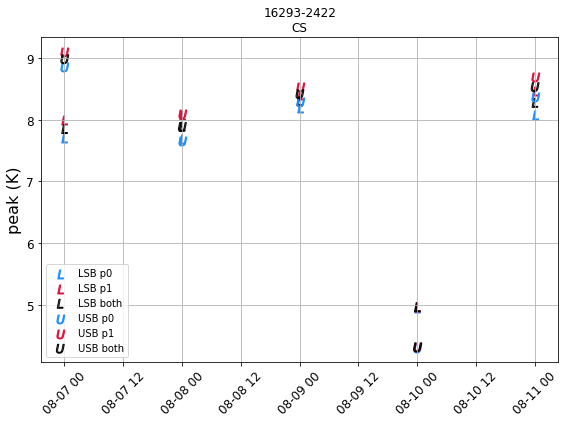

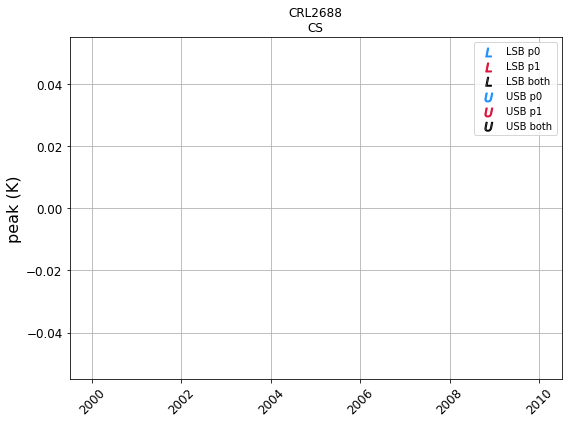

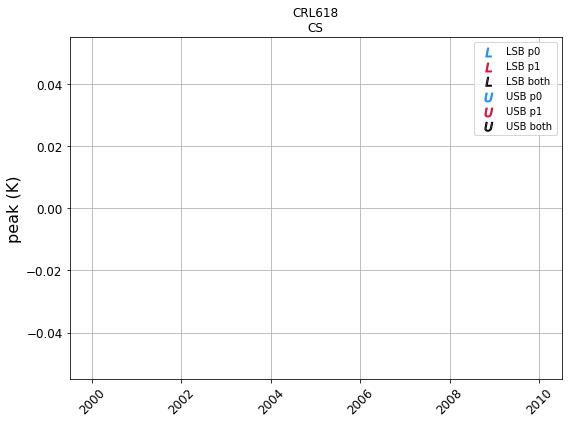

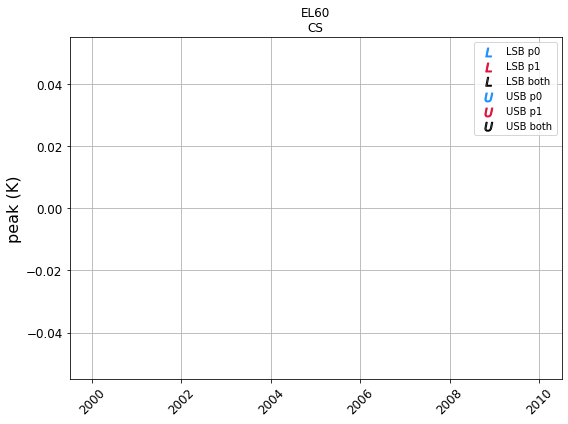

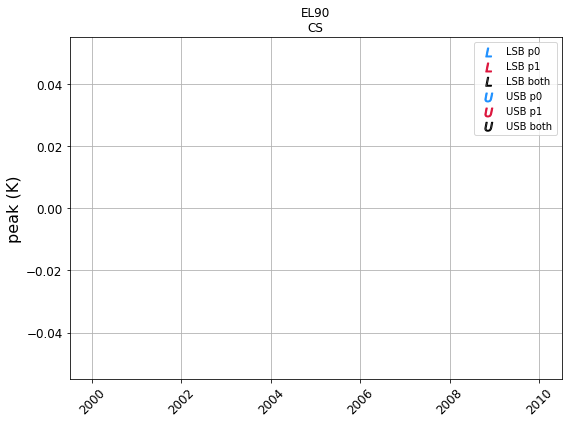

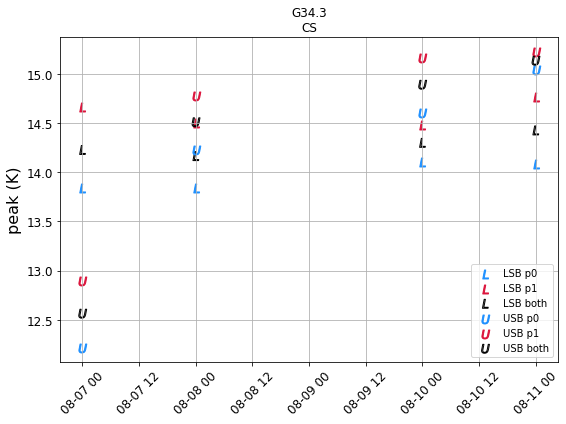

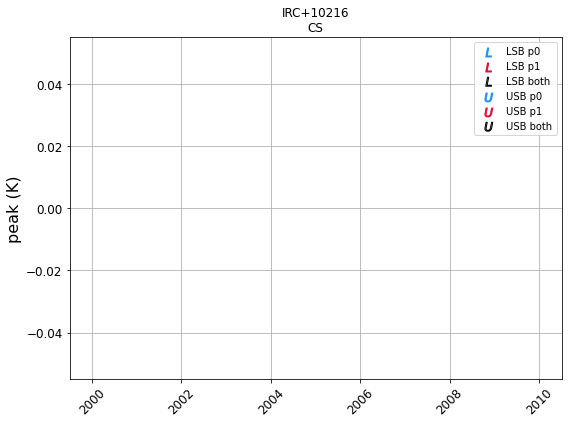

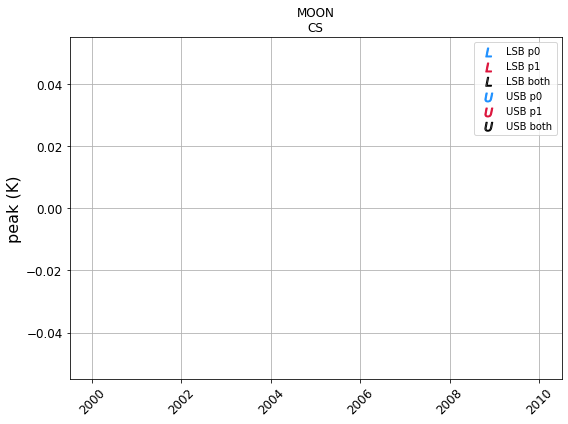

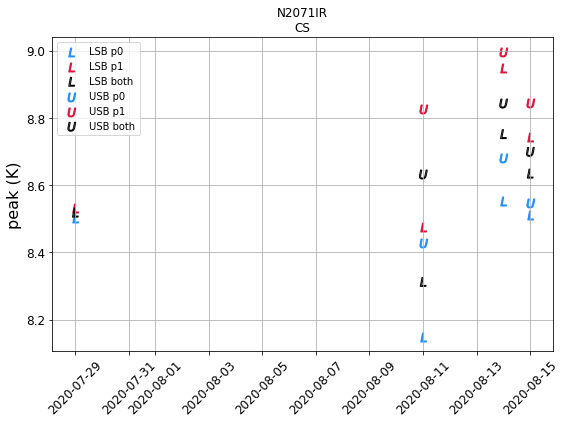

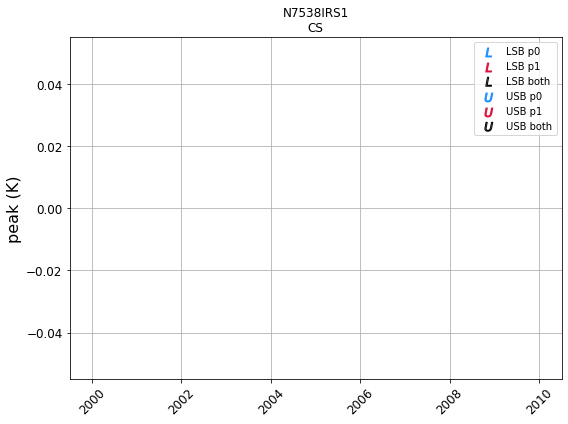

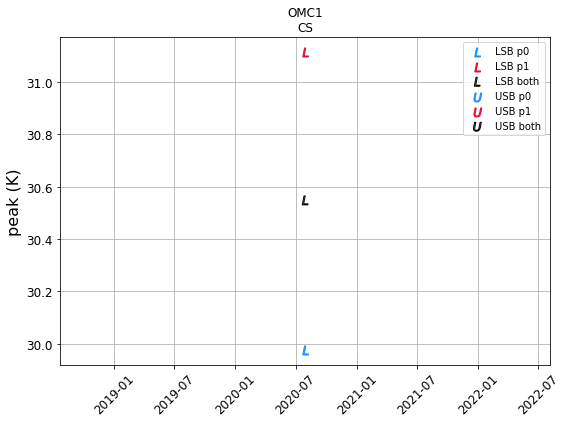

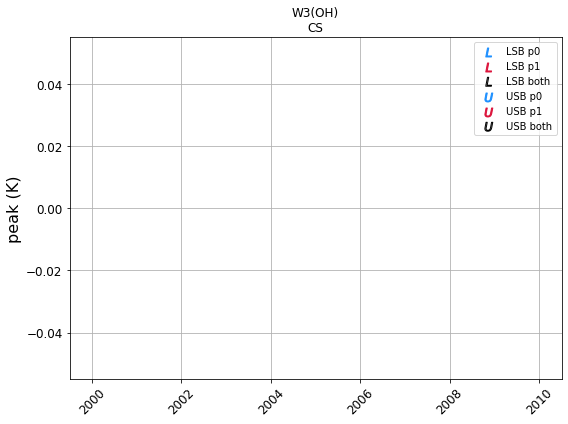

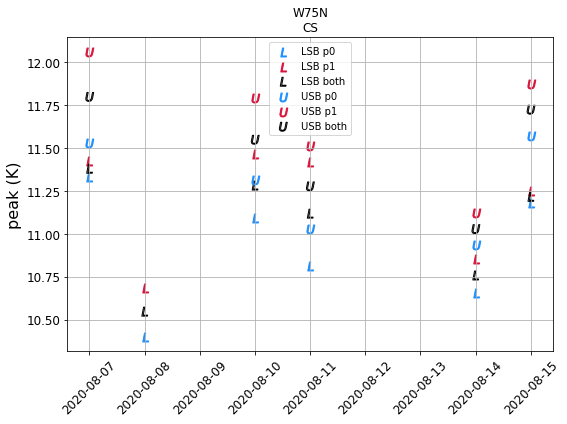

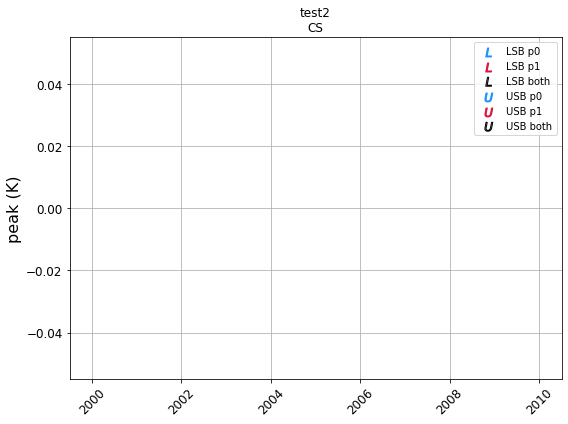

In [43]:
# Sideband and pol vs utdate for CS

bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p0','p1','both']

molecule = "CS"
if(os.path.isdir('figures/'+molecule)==0): os.mkdir('figures/'+molecule)
for target in np.unique(data['object']):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for sb in sb_:
        for pol in pol_:
            if(pol == 'p0'): 
                color = 'dodgerblue'
                fc ='dodgerblue' 
            elif(pol == 'p1'):
                color = 'crimson'
                fc = 'crimson'
            elif(pol=='both'): 
                color ='black'
                fc = 'none'
            #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
            marker = '$U$' if sb == 'USB' else '$L$'
            d = data[(data['object'] == target) & (data['sideband'] == sb) & (data['bwmode']== bw_) &
                     (data['pol'] == pol) & (data['molecule'] == molecule)]
            x = d['Date'];  y = d['peak']
            ax.scatter(x, y, s=80, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+pol)
    #ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
    plt.title(target + '\n'+ molecule)
    plt.legend()
    plt.ylabel('peak (K)', fontsize = 16)
    ax.tick_params('x', labelrotation=45, labelsize=12)
    ax.tick_params('y', labelsize=12)
    fig.tight_layout()
    fig.savefig('figures/'+molecule +"/"+target+'_'+molecule+'_pol_peak.png')

In [ ]:
# Sideband and pol vs Tsys for CO
bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p0','p1','both']

molecule = "CO"
if(os.path.isdir('figures/'+molecule)==0): os.mkdir('figures/'+molecule)

for target in np.unique(data['object']):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for sb in sb_:
        for pol in pol_:
            if(pol == 'p0'): 
                color = 'dodgerblue'
                fc ='dodgerblue' 
            elif(pol == 'p1'):
                color = 'crimson'
                fc = 'crimson'
            elif(pol=='both'): 
                color ='black'
                fc = 'none'
            #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
            marker = '$U$' if sb == 'USB' else '$L$'
            d = data[(data['object'] == target) & (data['sideband'] == sb) & (data['bwmode']== bw_) &
                     (data['pol'] == pol) & (data['molecule'] == molecule)]
            x = d['tsys'];  y = d['peak']
            ax.scatter(x, y, s=80, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+pol)
    #ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
    plt.title(target + '\n'+ molecule)
    plt.legend()
    plt.ylabel('peak (K)', fontsize = 16)
    plt.xlabel('Tsys (K)', fontsize = 16)    
    ax.tick_params('x', labelrotation=0, labelsize=12)
    ax.tick_params('y', labelsize=12)
    fig.tight_layout()
    fig.savefig('figures/'+target+'_'+molecule+'_Tsys_pol_peak.png')
    fig.savefig('figures/'+molecule +"/"+target+'_'+molecule+'_Tsys_pol_peak.png')

In [ ]:
# Sideband and pol vs Tsys for CS
bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p0','p1','both']

molecule = "CS"
if(os.path.isdir('figures/'+molecule)==0): os.mkdir('figures/'+molecule)

for target in np.unique(data['object']):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for sb in sb_:
        for pol in pol_:
            if(pol == 'p0'): 
                color = 'dodgerblue'
                fc ='dodgerblue' 
            elif(pol == 'p1'):
                color = 'crimson'
                fc = 'crimson'
            elif(pol=='both'): 
                color ='black'
                fc = 'none'
            #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
            marker = '$U$' if sb == 'USB' else '$L$'
            d = data[(data['object'] == target) & (data['sideband'] == sb) & (data['bwmode']== bw_) &
                     (data['pol'] == pol) & (data['molecule'] == molecule)]
            x = d['tsys'];  y = d['peak']
            ax.scatter(x, y, s=80, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+pol)
    #ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
    plt.title(target + '\n'+ molecule)
    plt.legend()
    plt.ylabel('peak (K)', fontsize = 16)
    plt.xlabel('Tsys (K)', fontsize = 16)    
    ax.tick_params('x', labelrotation=0, labelsize=12)
    ax.tick_params('y', labelsize=12)
    fig.tight_layout()
    fig.savefig('figures/'+molecule +"/"+target+'_'+molecule+'_Tsys_pol_peak.png')

### Sideband and pol vs Tsys for all CO sample

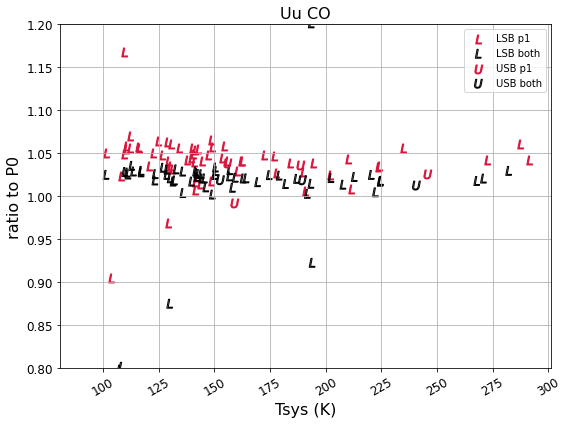

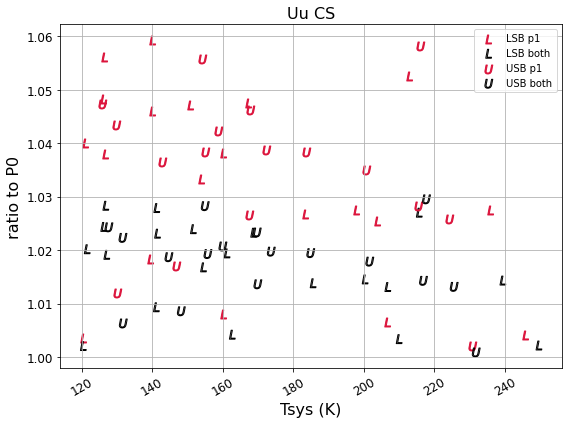

In [44]:
bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p1','both']

molecule_ = ["CO", 'CS']

#for target in np.unique(data['object']):
for molecule in molecule_:
    fig = plt.figure(figsize=(8,6),)
    ax = fig.add_subplot(111)
    for sb in sb_:
        for pol in pol_:
            if(pol == 'p0'): 
                    color =   fc ='dodgerblue' 
            elif(pol == 'p1'):
                    color =   fc = 'crimson'
            elif(pol=='both'): 
                color ='black'
                fc = 'none'
            #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
            marker = '$U$' if sb == 'USB' else '$L$'
            d = data[(data['sideband'] == sb) & (data['bwmode']== bw_) &
                     (data['pol'] == pol) & (data['molecule'] == molecule)]
            x = d['tsys'];  y = d['ratio_to_p0']
            ax.scatter(x, y, s=80, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+pol)
    #ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
    plt.title('Uu ' + molecule, fontsize = 16)
    plt.legend()
    if molecule == 'CO': plt.ylim(0.8,1.2)
    plt.ylabel('ratio to P0', fontsize = 16)
    plt.xlabel('Tsys (K)', fontsize = 16)    
    ax.tick_params('x', labelrotation=30, labelsize=12)
    ax.tick_params('y', labelsize=12)
    fig.tight_layout()
    fig.savefig('figures/'+molecule+'_tsys_p0-ratio.png', dpi=120)

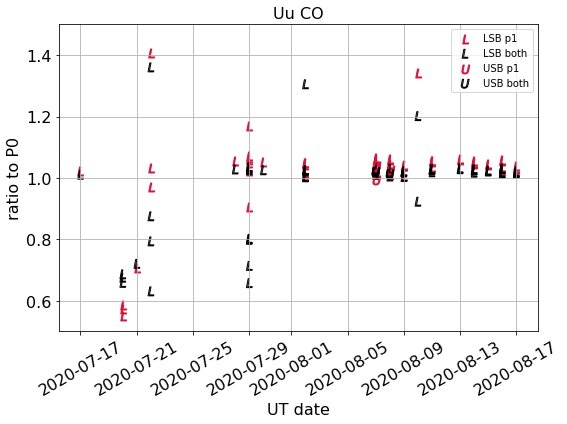

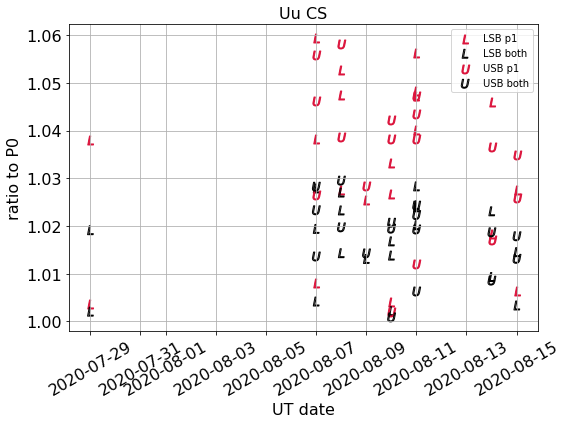

In [45]:
bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p1','both']

molecule = ["CO", 'CS']

#for target in np.unique(data['object']):
for molecule in molecule_:
    fig = plt.figure(figsize=(8,6),)
    ax = fig.add_subplot(111)
    for sb in sb_:
        for pol in pol_:
            if(pol == 'p0'): 
                    color =   fc ='dodgerblue' 
            elif(pol == 'p1'):
                    color =   fc = 'crimson'
            elif(pol=='both'): 
                color ='black'
                fc = 'none'
            #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
            marker = '$U$' if sb == 'USB' else '$L$'
            d = data[(data['sideband'] == sb) & (data['bwmode']== bw_) &
                     (data['pol'] == pol) & (data['molecule'] == molecule)]
            x = d['Date'];  y = d['ratio_to_p0']
            ax.scatter(x, y, s=80, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+pol)
    #ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
    plt.title('Uu ' + molecule, fontsize = 16)
    plt.legend()
    if molecule == 'CO': plt.ylim(0.5,1.5)
    plt.ylabel('ratio to P0', fontsize = 16)
    plt.xlabel('UT date', fontsize = 16)    
    ax.tick_params('x', labelrotation=30, labelsize=16)
    ax.tick_params('y', labelsize=16)
    fig.tight_layout()
    fig.savefig('figures/'+molecule+'_ut_p0-ratio.png', dpi=120)

## BOXplot

CO LSB p1 60
CO LSB both 60
CO USB p1 4
CO USB both 3
CS LSB p1 20
CS LSB both 20
CS USB p1 17
CS USB both 17


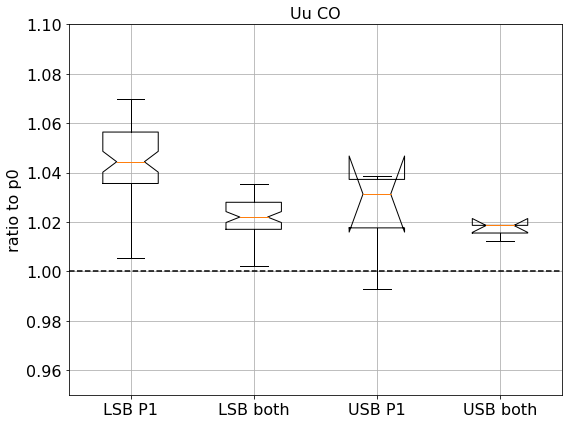

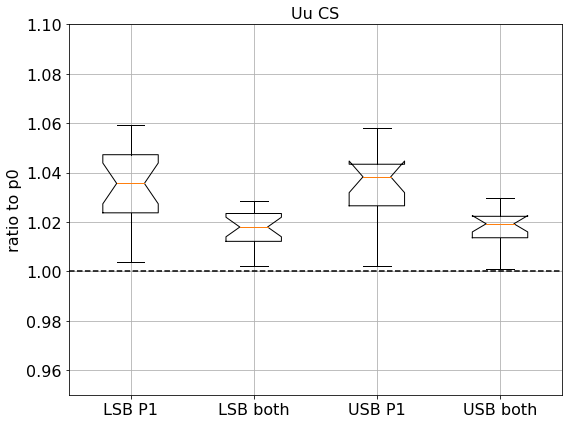

In [47]:
bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p1','both']

molecule_ = ["CO",'CS']

#p0ratio.append(p0data['ratio_to_p0'])

#for target in np.unique(data['object']):
for molecule in molecule_:
    p0ratio = []
    fig = plt.figure(figsize=(8,6),)
    ax = fig.add_subplot(111)
    for sb in sb_:
        for pol in pol_:
            if(pol == 'p0'): 
                    color =   fc ='dodgerblue' 
            elif(pol == 'p1'):
                    color =   fc = 'crimson'
            elif(pol=='both'): 
                color ='black'
                fc = 'none'
            #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
            marker = '$U$' if sb == 'USB' else '$L$'
            d = data[(data['sideband'] == sb) & (data['bwmode']== bw_) &
                     (data['pol'] == pol) & (data['molecule'] == molecule) &
                     (data['utdate']>=20200729)]
            x = d['tsys'];  y = d.ratio_to_p0
            print(molecule, sb, pol, len(y))
            p0ratio.append(y)
    ax.boxplot(p0ratio, notch=True, sym='x', labels=['LSB P1','LSB both','USB P1','USB both'])
    ax.axhline(1, c='black', linestyle='--')
    #ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
    plt.title('Uu ' + molecule, fontsize = 16)
    #plt.legend()
    plt.ylim(0.95,1.10)
    plt.ylabel('ratio to p0', fontsize = 16)
    #plt.xlabel('Tsys (K)', fontsize = 16)    
    ax.tick_params('x', labelrotation=0, labelsize=16)
    ax.tick_params('y', labelsize=16)
    fig.tight_layout()
    fig.savefig('figures/'+molecule+'_p0-ratio_boxplot.png', dpi=120)

# LOFREQ

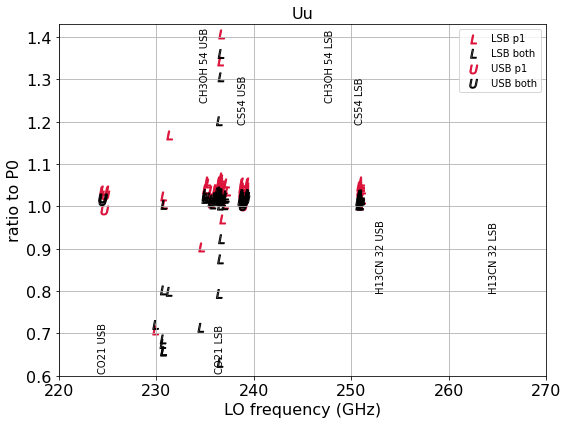

In [48]:
# Sideband and pol vs Tsys, plotted as ratio_to_pol0
bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p1','both']

#molecule = "CS"
#for target in np.unique(data['object']):
fig = plt.figure(figsize=(8,6),)
ax = fig.add_subplot(111)
for sb in sb_:
    for pol in pol_:
        if(pol == 'p0'): 
            color = 'dodgerblue'
            fc ='dodgerblue' 
        elif(pol == 'p1'):
            color = 'crimson'
            fc = 'crimson'
        elif(pol=='both'): 
            color ='black'
            fc = 'none'
        #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
        marker = '$U$' if sb == 'USB' else '$L$'
        d = data[(data['sideband'] == sb) & (data['bwmode']== bw_) & 
                 (data['pol'] == pol)]
        x = d['lofreqs']+np.random.normal(0, 0.1, len(d));  y = d['ratio_to_p0']
        ax.scatter(x, y, s=80, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+pol)
#ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
plt.title("Uu" , fontsize=16)
plt.grid('off')
plt.text(236.535, 0.61, "CO21 LSB",horizontalalignment='center', rotation=90)
plt.text(224.535, 0.61, "CO21 USB",horizontalalignment='center', rotation=90)
plt.text(250.933, 1.2, "CS54 LSB",horizontalalignment='center', rotation=90)
plt.text(238.929, 1.2, "CS54 USB",horizontalalignment='center', rotation=90)
plt.text(247.785, 1.25, "CH3OH 54 LSB",horizontalalignment='center', rotation=90)
plt.text(235., 1.25, "CH3OH 54 USB",horizontalalignment='center', rotation=90)
plt.text(264.639, 0.8, "H13CN 32 LSB",horizontalalignment='center', rotation=90)
plt.text(253.039, 0.8, "H13CN 32 USB",horizontalalignment='center', rotation=90)

plt.ylabel('ratio to P0', fontsize = 16)
plt.xlabel('LO frequency (GHz)', fontsize = 16)
plt.ylim(0.6,1.43)
#plt.ylim(0.8,1.2)
plt.xlim(220, 270)

ax.tick_params('x', labelrotation=0, labelsize=16)
ax.tick_params('y', labelsize=16)
plt.legend()

fig.tight_layout()
fig.savefig('figures/'+'lofreq_p0-ratio.png', dpi=120)

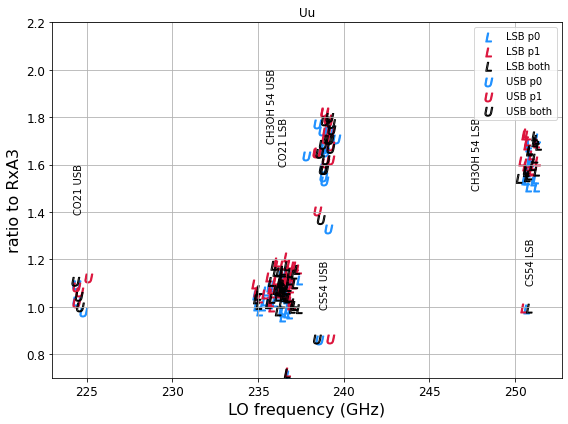

In [50]:
# Sideband and pol vs Tsys for all CS, plotted as ratio to RxA3
bw_ = '1000MHzx2048'
sb_ = ['LSB','USB']
pol_= ['p0','p1','both']

molecule = "CS"
#for target in np.unique(data['object']):
fig = plt.figure(figsize=(8,6),)
ax = fig.add_subplot(111)
for sb in sb_:
    for pol in pol_:
        if(pol == 'p0'): 
            color = 'dodgerblue'
            fc ='dodgerblue' 
        elif(pol == 'p1'):
            color = 'crimson'
            fc = 'crimson'
        elif(pol=='both'): 
            color ='black'
            fc = 'none'
        #fc = 'black' if pol == 'both' else 'dodgerblue' if pol=='p0' else 'crimson'
        marker = '$U$' if sb == 'USB' else '$L$'
        d = data[(data['sideband'] == sb) & (data['bwmode']== bw_) & 
                 (data['pol'] == pol)]
        x = d['lofreqs']+np.random.normal(0, 0.3, len(d));  y = d['ratio_to_'+receiver]
        ax.scatter(x, y, s=80, edgecolors=color, marker=marker, facecolors=fc, label=sb+' '+pol)
#ax.hlines(0, min(data['Date']), max(data['Date']), ls='--')
plt.title("Uu")
plt.legend()
plt.grid('off')
plt.text(236.535, 1.6, "CO21 LSB",horizontalalignment='center', rotation=90)
plt.text(224.535, 1.4, "CO21 USB",horizontalalignment='center', rotation=90)
plt.text(250.933, 1.1, "CS54 LSB",horizontalalignment='center', rotation=90)
plt.text(238.929, 1.0, "CS54 USB",horizontalalignment='center', rotation=90)
plt.text(247.785, 1.5, "CH3OH 54 LSB",horizontalalignment='center', rotation=90)
plt.text(235.788, 1.7, "CH3OH 54 USB",horizontalalignment='center', rotation=90)

plt.ylabel('ratio to RxA3', fontsize = 16)
plt.xlabel('LO frequency (GHz)', fontsize = 16)
plt.ylim(0.7,2.2)
ax.tick_params('x', labelrotation=0, labelsize=12)
ax.tick_params('y', labelsize=12)
fig.tight_layout()
fig.savefig('figures/'+'lofreq_pol_RxA-ratio.png', dpi=120)